### Import

In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt

### Load Data

In [3]:
dtypes = {
    'defaultPaymentMethod': str,
    'mode': str,
    'serviceClassificationName': str,
    'state': str,
    'address_county': str,
    'address_district': str,
    'discount_type': str,
    'subtotal': float,
    'travelingExpense': float,
    'discountNum': float,
    'isServicePackageBooking': float
}

In [4]:
df_main = pd.read_csv(
    r'C:\Users\USER\OneDrive\Documents\DSC_Project\20250517_資料集\一般訂單\main.csv',
    dtype=dtypes,
    low_memory=False
)

### Feature engineering

#### days_until_next_order


In [5]:
# Feature engineering (unchanged)
df_date_only = df_main['createdAt']
df_date_only = pd.to_datetime(df_date_only)
df_date_only = df_date_only.dt.date
df_main['only_date'] = df_date_only

df_main = df_main.sort_values(['user_oid', 'only_date']).reset_index(level=0, drop=True)
df_main['only_date'] = pd.to_datetime(df_main['only_date'])
df_main['next_order_date'] = df_main.groupby('user_oid')['only_date'].shift(-1)
df_main['next_order_date'] = pd.to_datetime(df_main['next_order_date'])
df_main['days_until_next_order'] = (df_main['next_order_date'] - df_main['only_date']).dt.days


#### orders_last_365d

In [6]:
df_tmp = pd.DataFrame(df_main.groupby("user_oid").rolling("360D", on='only_date')['only_date'].count().shift(1).fillna(0).reset_index(level=0, drop=True))
df_tmp.columns = ['orders_last_365d']
df_tmp.reset_index(inplace=True)
df_main['orders_last_365d'] = df_tmp['orders_last_365d']

### Data preperation

In [7]:
# Data preparation (excluding address_hasElevator)
num_cols = ['subtotal', 'travelingExpense', 'discountNum', 'isServicePackageBooking','orders_last_365d']
cat_cols = ['defaultPaymentMethod', 'mode', 'serviceClassificationName', 'state',
            'address_county', 'address_district', 'discount_type']

# Define X and y
X = df_main[num_cols + cat_cols].copy()
y = df_main['days_until_next_order'].copy()

for col in cat_cols:
    X[col] = X[col].astype(str)  # Ensure categorical columns are strings
    
y = y.apply(lambda x: 0 if pd.isna(x) or x > 365 else 1)
groups = df_main["user_oid"]


### Minimal preprocessing block

In [8]:
# Preprocessing pipeline
prep = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), cat_cols)
    ],
    remainder='drop'
)

### Model and Pipline

In [9]:
lgbm = LGBMClassifier(
    objective='binary',
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=63,
    random_state=42
)
pipe = Pipeline([('prep', prep), ('model', lgbm)])

### Train / Test split

In [10]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

### Fit

In [11]:
pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
pred = pipe.predict(X.iloc[test_idx])
pred_proba = pipe.predict_proba(X.iloc[test_idx])[:, 1]  # Probabilities for Class 1

[LightGBM] [Info] Number of positive: 7441, number of negative: 14813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 22254, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334367 -> initscore=-0.688500
[LightGBM] [Info] Start training from score -0.688500


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Eval

#### Confusion Matrix

Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83      3716
           1       0.75      0.37      0.49      1843

    accuracy                           0.75      5559
   macro avg       0.75      0.65      0.66      5559
weighted avg       0.75      0.75      0.72      5559



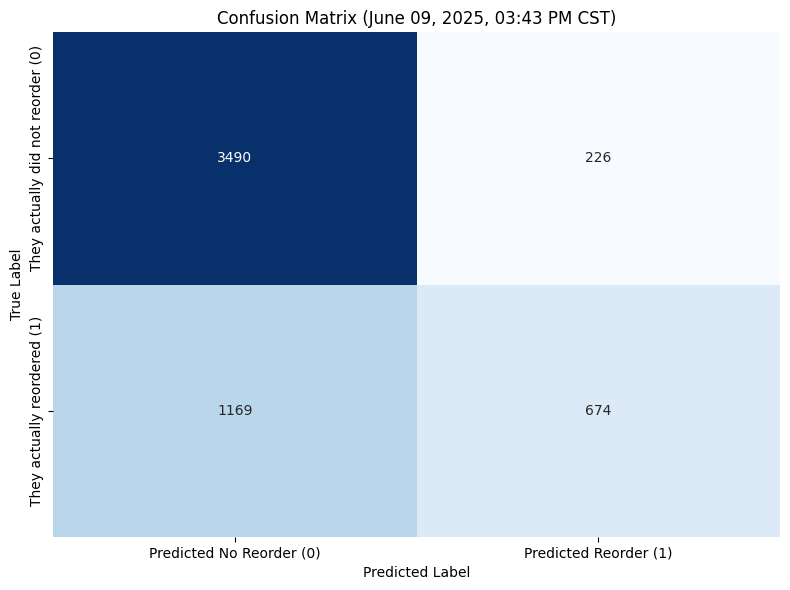


Confusion Matrix Values:
True Negatives (TN): 3490
False Positives (FP): 226
False Negatives (FN): 1169
True Positives (TP): 674


In [12]:
# Evaluate
print(f"Accuracy: {accuracy_score(y.iloc[test_idx], pred):.2f}")
print("\nClassification Report:")
print(classification_report(y.iloc[test_idx], pred))

# Generate and visualize confusion matrix with adjusted true labels
cm = confusion_matrix(y.iloc[test_idx], pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Reorder (0)', 'Predicted Reorder (1)'],
            yticklabels=['They actually did not reorder (0)', 'They actually reordered (1)'])
plt.title('Confusion Matrix (June 09, 2025, 03:43 PM CST)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Values:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

#### Normalize CM

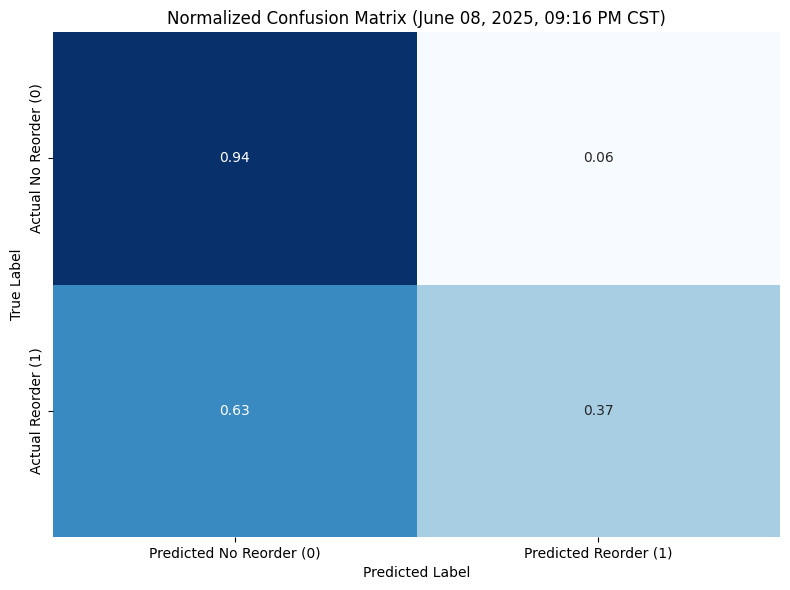

In [13]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Reorder (0)', 'Predicted Reorder (1)'],
            yticklabels=['Actual No Reorder (0)', 'Actual Reorder (1)'])
plt.title('Normalized Confusion Matrix (June 08, 2025, 09:16 PM CST)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#### GroupKFold (Ensure Robustness)

In [14]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[val_idx])
    cm = confusion_matrix(y.iloc[val_idx], pred)
    print(f"\nFold {fold+1} Confusion Matrix:")
    print(cm)

[LightGBM] [Info] Number of positive: 7411, number of negative: 14839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 22250, number of used features: 151
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333079 -> initscore=-0.694293
[LightGBM] [Info] Start training from score -0.694293


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Fold 1 Confusion Matrix:
[[3440  250]
 [1153  720]]
[LightGBM] [Info] Number of positive: 7429, number of negative: 14821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 22250, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333888 -> initscore=-0.690654
[LightGBM] [Info] Start training from score -0.690654


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Fold 2 Confusion Matrix:
[[3469  239]
 [1129  726]]
[LightGBM] [Info] Number of positive: 7441, number of negative: 14809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 22250, number of used features: 155
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334427 -> initscore=-0.688230
[LightGBM] [Info] Start training from score -0.688230


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Fold 3 Confusion Matrix:
[[3472  248]
 [1162  681]]
[LightGBM] [Info] Number of positive: 7441, number of negative: 14810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 22251, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334412 -> initscore=-0.688297
[LightGBM] [Info] Start training from score -0.688297


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Fold 4 Confusion Matrix:
[[3480  239]
 [1133  710]]
[LightGBM] [Info] Number of positive: 7414, number of negative: 14837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 22251, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333199 -> initscore=-0.693754
[LightGBM] [Info] Start training from score -0.693754

Fold 5 Confusion Matrix:
[[3484  208]
 [1153  717]]


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### ROC & AUC Curve

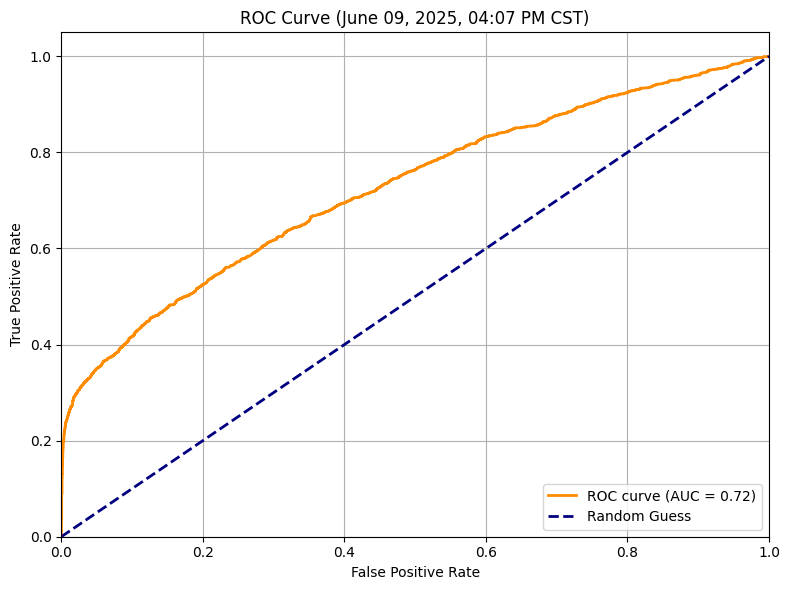


AUC Score: 0.72


In [15]:
fpr, tpr, thresholds = roc_curve(y.iloc[test_idx], pred_proba)
auc = roc_auc_score(y.iloc[test_idx], pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (June 09, 2025, 04:07 PM CST)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nAUC Score: {auc:.2f}")

### G Mean

In [17]:
recall_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])
recall_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])
gmean = np.sqrt(recall_0 * recall_1)
print(f"\nG-Mean (Adjusted Threshold): {gmean:.4f}")
print(f"Recall Class 0 (Specificity): {recall_0:.4f}")
print(f"Recall Class 1 (Sensitivity): {recall_1:.4f}")


G-Mean (Adjusted Threshold): 0.6015
Recall Class 0 (Specificity): 0.9437
Recall Class 1 (Sensitivity): 0.3834
